In [1]:
import pandas as pd
import pyarrow as pa
import pyarrow.csv as csv
import datetime
import folium
import time
import geopandas

In [2]:
data=pd.read_csv('../../../data/stop_activity_granular_2020-09-01_2020-10-31.csv', engine='pyarrow')

In [3]:
df=data.copy()

In [4]:
len(df)

22506627

In [5]:
df.head()

,OPERATION_DATE,BOOKING_ID,SCHED_DAY_TYPE_CODED_NUM,SERVICE_RTE_LIST,TRIP_COMPASS_DIR_CD,KEY_BLOCK_NUM,STOP_SEQUENCE_NUM,STOP_ID,STOP_NM,SCHED_ARRIVAL_SECS_AFTER_MIDNT,FULL_DATE,ACTUAL_ARRIVAL_SECS_AFTER_MIDNT,ACTUAL_DEPARTURE_SECS_AFTER_MIDNT,PSNGR_BOARDINGS,PSNGR_ALIGHTINGS,TRIP_ID,DEP_PSNGR_LOAD
0,2020-09-01,SUM20,0,65,North,6503,13.0,10020,NE 55TH ST & 37TH AVE NE,NaN,09/01/2020,110709,110709,0,0,46931260,2
1,2020-09-01,SUM20,0,120,North,12011,32.0,21560,DELRIDGE WAY SW & SW HUDSON ST,NaN,09/01/2020,123209,123209,0,0,47583182,0
2,2020-09-01,SUM20,0,107,NULL,10714,0.0,41890,S LANDER ST & 15TH AVE S,155200.0,09/01/2020,155345,155345,0,0,47801614,0
3,2020-09-01,SUM20,0,120,NULL,12024,1.0,98141,2ND AVE & LENORA ST,124400.0,09/01/2020,124003,124003,0,0,47583379,0
4,2020-09-01,SUM20,0,671,South,67111,5.0,61100,INTERNATIONAL BLVD & S 188TH ST,NaN,09/01/2020,133751,133818,4,0,47799588,5


In [6]:
len(set(df['FULL_DATE']))

60

In [7]:
len(set(df['STOP_ID']))

5993

In [8]:
len(set(df['SERVICE_RTE_LIST']))

152

In [9]:
len(set(df['TRIP_ID']))

82027

In [10]:
df['PSNGR_ALIGHTINGS'].describe()

count    2.250663e+07
mean     2.784130e-01
std      9.474394e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.080000e+02
Name: PSNGR_ALIGHTINGS, dtype: float64

In [11]:
df.isnull().sum()

OPERATION_DATE                              0
BOOKING_ID                                  0
SCHED_DAY_TYPE_CODED_NUM                    0
SERVICE_RTE_LIST                            0
TRIP_COMPASS_DIR_CD                         0
KEY_BLOCK_NUM                               0
STOP_SEQUENCE_NUM                        2441
STOP_ID                                     0
STOP_NM                                     0
SCHED_ARRIVAL_SECS_AFTER_MIDNT       17238389
FULL_DATE                                   0
ACTUAL_ARRIVAL_SECS_AFTER_MIDNT             0
ACTUAL_DEPARTURE_SECS_AFTER_MIDNT           0
PSNGR_BOARDINGS                             0
PSNGR_ALIGHTINGS                            0
TRIP_ID                                     0
DEP_PSNGR_LOAD                              0
dtype: int64

In [12]:
df['PSNGR_ACTIVITY']=df['PSNGR_ALIGHTINGS']+df['PSNGR_BOARDINGS']

In [13]:
df['FULL_DATE']=pd.to_datetime(df['FULL_DATE'])

In [14]:
df['OPERATION_DATE']=pd.to_datetime(df['OPERATION_DATE'])

In [15]:
df['ACTUAL_DEPARTURE_SECS_AFTER_MIDNT']=pd.to_datetime(df['ACTUAL_DEPARTURE_SECS_AFTER_MIDNT'],unit='s')

Looking for most popular stops for morning and evening rush hours. To see where people commute to and from work, this should align with data on work tract and household tract. 

Where do we want to focus on


In [16]:
df['ACTUAL_DEPARTURE_SECS_AFTER_MIDNT']=df['ACTUAL_DEPARTURE_SECS_AFTER_MIDNT'].dt.time

<AxesSubplot:xlabel='OPERATION_DATE'>

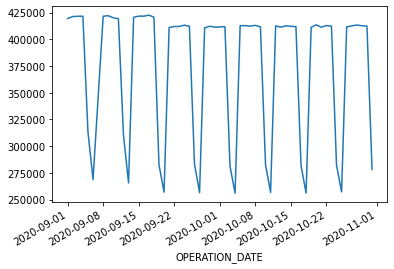

In [17]:
df.value_counts('OPERATION_DATE').plot()

In [18]:
m_start=datetime.time(6,30,0)
m_end=datetime.time(9,0,0)
e_start=datetime.time(17,0,0)
e_end=datetime.time(19,0,0)

In [ ]:
df['ACTUAL_DEPARTURE_SECS_AFTER_MIDNT']

In [ ]:
df_m_rush=df[(df['ACTUAL_DEPARTURE_SECS_AFTER_MIDNT']>m_start) & (df['ACTUAL_DEPARTURE_SECS_AFTER_MIDNT']<m_end)]

In [ ]:
filtered_df = df_m_rush.loc[(df_m_rush['OPERATION_DATE'] == '2020-09-01')]

In [ ]:
top_morning=filtered_df.groupby('STOP_ID').agg({'PSNGR_ACTIVITY':'mean','STOP_NM':'first'}).nlargest(10,'PSNGR_ACTIVITY')

In [ ]:
top_morning

In [ ]:
geoloc=pd.read_csv('FinalData/raw_data/1_gtfs/stops.txt')
geoloc['geometry'] = geopandas.points_from_xy(geoloc['stop_lon'], geoloc['stop_lat'])

In [ ]:
morning=geoloc.merge(top_morning, how='inner', right_on='STOP_ID',left_on="stop_id")
morning

In [ ]:
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in morning.geometry ]
mapping = folium.Map(location = [47.59789702474227, -122.31735261797544], tiles = "Stamen Terrain", zoom_start = 10)
i=0
for coordinates in geo_df_list[:10]:
    mapping.add_child(folium.Marker(location = coordinates,popup =
                            "Name: " + str(morning.stop_name[i]) + '<br>',
                            icon = folium.Icon()))
    i = i + 1

In [ ]:
mapping

Repeating the same process for evening rush hours for the first date

In [ ]:
df_e_rush=df[(df['ACTUAL_DEPARTURE_SECS_AFTER_MIDNT']>e_start) & (df['ACTUAL_DEPARTURE_SECS_AFTER_MIDNT']<e_end)]

In [ ]:
top_evening=df_e_rush.loc[(df_e_rush['OPERATION_DATE'] == '2020-09-01')].groupby('STOP_ID').agg({'PSNGR_ACTIVITY':'mean','STOP_NM':'first'}).nlargest(10,'PSNGR_ACTIVITY')

In [ ]:
evening=geoloc.merge(top_evening, how='inner', right_on='STOP_ID',left_on="stop_id")
evening

In [ ]:
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in evening.geometry ]
mapping = folium.Map(location = [47.59789702474227, -122.31735261797544], tiles = "OpenStreetMap", zoom_start = 10)
i=0
for coordinates in geo_df_list[:10]:
    mapping.add_child(folium.Marker(location = coordinates,popup =
                            "Name: " + str(evening.stop_name[i]) + '<br>',
                            icon = folium.Icon()))
    i = i + 1

In [ ]:
mapping

In [ ]:
df_e_rush=df[(df['ACTUAL_DEPARTURE_SECS_AFTER_MIDNT']>e_start) & (df['ACTUAL_DEPARTURE_SECS_AFTER_MIDNT']<e_end)]

top_evening=df_e_rush.groupby('STOP_ID').agg({'PSNGR_ACTIVITY':'mean','STOP_NM':'first'}).nlargest(10,'PSNGR_ACTIVITY')

evening=geoloc.merge(top_evening, how='inner', right_on='STOP_ID',left_on="stop_id")
evening

geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in evening.geometry ]
mapping = folium.Map(location = [47.59789702474227, -122.31735261797544], tiles = "OpenStreetMap", zoom_start = 10)
i=0
for coordinates in geo_df_list[:10]:
    mapping.add_child(folium.Marker(location = coordinates,popup =
                            "Name: " + str(evening.stop_name[i]) + '<br>',
                            icon = folium.Icon()))
    i = i + 1

mapping

In [ ]:
df_e_rush=df[(df['ACTUAL_DEPARTURE_SECS_AFTER_MIDNT']>e_start) & (df['ACTUAL_DEPARTURE_SECS_AFTER_MIDNT']<e_end)]

top_evening=df_e_rush.loc[(df_e_rush['OPERATION_DATE'] == '2020-09-01')].groupby('STOP_ID').agg({'PSNGR_ALIGHTINGS':'mean','STOP_NM':'first'}).nlargest(10,'PSNGR_ALIGHTINGS')

evening=geoloc.merge(top_evening, how='inner', right_on='STOP_ID',left_on="stop_id")
evening

geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in evening.geometry ]
mapping = folium.Map(location = [47.59789702474227, -122.31735261797544], tiles = "OpenStreetMap", zoom_start = 10)
i=0
for coordinates in geo_df_list[:10]:
    mapping.add_child(folium.Marker(location = coordinates,popup =
                            "Name: " + str(evening.stop_name[i]) + '<br>',
                            icon = folium.Icon()))
    i = i + 1

mapping

In [ ]:
df_e_rush=df[(df['ACTUAL_DEPARTURE_SECS_AFTER_MIDNT']>e_start) & (df['ACTUAL_DEPARTURE_SECS_AFTER_MIDNT']<e_end)]

top_evening=df_e_rush.groupby('STOP_ID').agg({'PSNGR_BOARDINGS':'mean','STOP_NM':'first'}).nlargest(10,'PSNGR_BOARDINGS')

evening=geoloc.merge(top_evening, how='inner', right_on='STOP_ID',left_on="stop_id")
evening

geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in evening.geometry ]
mapping = folium.Map(location = [47.59789702474227, -122.31735261797544], tiles = "OpenStreetMap", zoom_start = 10)
i=0
for coordinates in geo_df_list[:10]:
    mapping.add_child(folium.Marker(location = coordinates,popup =
                            "Name: " + str(evening.stop_name[i]) + '<br>',
                            icon = folium.Icon()))
    i = i + 1

mapping

In [ ]:
df_m_rush=df[(df['ACTUAL_DEPARTURE_SECS_AFTER_MIDNT']>m_start) & (df['ACTUAL_DEPARTURE_SECS_AFTER_MIDNT']<m_end)]

top_evening=df_m_rush.loc[(df_m_rush['OPERATION_DATE'] == '2020-09-01')].groupby('STOP_ID').agg({'PSNGR_ALIGHTINGS':'mean','STOP_NM':'first'}).nlargest(10,'PSNGR_ALIGHTINGS')

morning=geoloc.merge(top_evening, how='inner', right_on='STOP_ID',left_on="stop_id")


geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in morning.geometry ]
mapping = folium.Map(location = [47.59789702474227, -122.31735261797544], tiles = "OpenStreetMap", zoom_start = 10)
i=0
for coordinates in geo_df_list[:10]:
    mapping.add_child(folium.Marker(location = coordinates,popup =
                            "Name: " + str(evening.stop_name[i]) + '<br>',
                            icon = folium.Icon()))
    i = i + 1

mapping

In [ ]:
df_m_rush=df[(df['ACTUAL_DEPARTURE_SECS_AFTER_MIDNT']>m_start) & (df['ACTUAL_DEPARTURE_SECS_AFTER_MIDNT']<m_end)]

top_evening=df_m_rush.loc[(df_m_rush['OPERATION_DATE'] == '2020-09-01')].groupby('STOP_ID').agg({'PSNGR_BOARDINGS':'mean','STOP_NM':'first'}).nlargest(10,'PSNGR_BOARDINGS')

morning=geoloc.merge(top_evening, how='inner', right_on='STOP_ID',left_on="stop_id")


geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in morning.geometry ]
mapping = folium.Map(location = [47.59789702474227, -122.31735261797544], tiles = "OpenStreetMap", zoom_start = 10)
i=0
for coordinates in geo_df_list[:10]:
    mapping.add_child(folium.Marker(location = coordinates,popup =
                            "Name: " + str(evening.stop_name[i]) + '<br>',
                            icon = folium.Icon()))
    i = i + 1

mapping